In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Replace with your correct path
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Quora_question_pair_partition/Quora_question_pair_partition/train.tsv', sep='\t')

df.columns = ['label', 'question1', 'question2', 'id']

# Preview
# df.head()

# Inspect the data
print(df.columns)
df.head()


Index(['label', 'question1', 'question2', 'id'], dtype='object')


,label,question1,question2,id
0,0,"Currently , all Supreme Court Justices come fr...",What 's your type of jungle -LRB- concrete or ...,221489
1,1,Why is saltwater taffy candy imported in Austr...,Why is salt water taffy candy unknown in Japan ?,92126
2,0,"Who has the better stable of characters , DC o...",Which is better - DC or Marvel ?,289278
3,1,What is difference between CAT and GMAT in ter...,What is the difference between the CAT and GMA...,328558
4,0,How can I stop being addicted to love ?,How can I stop being so addicted to my phone ?,113121


In [ ]:
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

# Apply cleaning
df['question1'] = df['question1'].apply(clean_text)
df['question2'] = df['question2'].apply(clean_text)


In [ ]:
# Combine all text to fit tokenizer
all_text = df['question1'].tolist() + df['question2'].tolist()

# Initialize tokenizer
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(all_text)

# Convert to sequences
q1_sequences = tokenizer.texts_to_sequences(df['question1'])
q2_sequences = tokenizer.texts_to_sequences(df['question2'])

# Padding
max_len = 30  # Can be tuned
q1_padded = pad_sequences(q1_sequences, maxlen=max_len, padding='post')
q2_padded = pad_sequences(q2_sequences, maxlen=max_len, padding='post')


In [ ]:
from sklearn.model_selection import train_test_split

X = np.hstack((q1_padded, q2_padded))  # Concatenate q1 and q2
y = df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Concatenate, Dropout

# Configs
vocab_size = 50000
embedding_dim = 128
max_len = 30

# Inputs
input_q1 = Input(shape=(max_len,))
input_q2 = Input(shape=(max_len,))

# Shared Embedding Layer
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)

q1_embed = embedding(input_q1)
q2_embed = embedding(input_q2)

# Shared GRU Layer
gru = GRU(64)

q1_encoded = gru(q1_embed)
q2_encoded = gru(q2_embed)

# Merge
merged = Concatenate()([q1_encoded, q2_encoded])
merged = Dropout(0.5)(merged)
dense = Dense(64, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(dense)

# Model
model = Model(inputs=[input_q1, input_q2], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 128)   │  6,400,000 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │     37,248 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ gru[0][0],        │
│ (Concatenate)       │                   │            │ gru[1][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,445,569 (24.59 MB)

 Trainable params: 6,445,569 (24.59 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X_train[:, :max_len], X_train[:, max_len:]],
    y_train,
    validation_data=([X_val[:, :max_len], X_val[:, max_len:]], y_val),
    epochs=5,
    batch_size=128
)


Epoch 1/5
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 542s 223ms/step - accuracy: 0.7051 - loss: 0.5689 - val_accuracy: 0.7693 - val_loss: 0.4784
Epoch 2/5
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 557s 221ms/step - accuracy: 0.7887 - loss: 0.4405 - val_accuracy: 0.7757 - val_loss: 0.4642
Epoch 3/5
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 544s 213ms/step - accuracy: 0.8220 - loss: 0.3771 - val_accuracy: 0.7866 - val_loss: 0.4632
Epoch 4/5
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 559s 212ms/step - accuracy: 0.8498 - loss: 0.3256 - val_accuracy: 0.7936 - val_loss: 0.4832
Epoch 5/5
2403/2403 ━━━━━━━━━━━━━━━━━━━━ 564s 212ms/step - accuracy: 0.8723 - loss: 0.2849 - val_accuracy: 0.7895 - val_loss: 0.5093


In [14]:
loss, acc = model.evaluate(
    [X_val[:, :max_len], X_val[:, max_len:]],
    y_val
)

print(f"Validation Loss: {loss:.4f}, Accuracy: {acc:.4f}")

2403/2403 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step - accuracy: 0.7891 - loss: 0.5105
Validation Loss: 0.5093, Accuracy: 0.7895


In [15]:
# Example: predict duplicate or not
sample_q1 = X_val[:, :max_len][:5]
sample_q2 = X_val[:, max_len:][:5]

pred_probs = model.predict([sample_q1, sample_q2])
predictions = (pred_probs > 0.5).astype(int)

print(predictions.ravel())


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
[0 1 0 0 1]


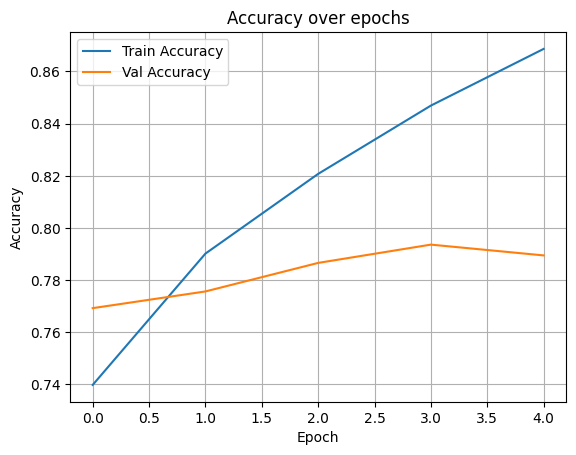

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
from sklearn.metrics import classification_report

y_pred = (model.predict([X_val[:, :max_len], X_val[:, max_len:]]) > 0.5).astype(int)
print(classification_report(y_val, y_pred))


2403/2403 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step
              precision    recall  f1-score   support

           0       0.86      0.80      0.83     48904
           1       0.69      0.77      0.73     27966

    accuracy                           0.79     76870
   macro avg       0.77      0.79      0.78     76870
weighted avg       0.80      0.79      0.79     76870



In [19]:
pred_probs = model.predict([X_val[:, :max_len], X_val[:, max_len:]])
predictions = (pred_probs > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_val, predictions))


2403/2403 ━━━━━━━━━━━━━━━━━━━━ 31s 13ms/step
              precision    recall  f1-score   support

           0       0.86      0.80      0.83     48904
           1       0.69      0.77      0.73     27966

    accuracy                           0.79     76870
   macro avg       0.77      0.79      0.78     76870
weighted avg       0.80      0.79      0.79     76870



In [21]:
model.save("quora_rnn_model_v1.keras")
